In [1]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import filters, measure, segmentation, color
from scipy.ndimage import gaussian_filter
from skimage.filters import difference_of_gaussians
import pandas as pd
from cellpose import models
from scipy import ndimage as ndi

In [2]:
# Loading data
# drug_name = ['Drug' + str(i) for i in range(1, 11)]

figName = '../Drug7_1000nM/rep1_FOV1.tif'
img = imread(str(figName))


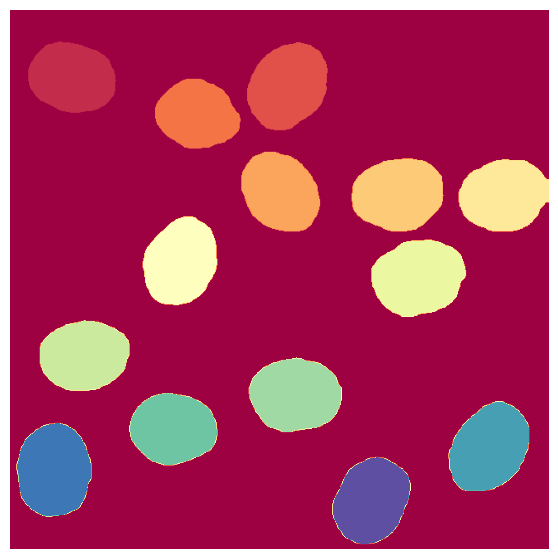

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


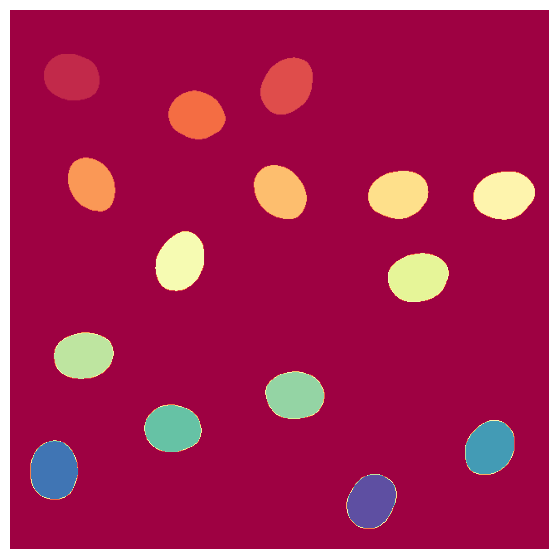

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [3]:
## Segmentation of cells and nucleus ———— to be replaced 

test1 = img[0, :, :, 1] # 'test1' to be changed
model1 = models.Cellpose(gpu = False, model_type = 'nuclei')

# Apply the model to your image
masks_cyto, flows, styles, diams = model1.eval(test1, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(figsize=(20, 7))
ax.imshow(masks_cyto,cmap='Spectral')
ax.axis('off')
plt.show()
print('Values in mask: ', np.unique (masks_cyto))

test2 = img[0, :, :, 0]
model2 = models.Cellpose(gpu = False, model_type = 'cyto')

# Apply the model to your image
masks_nuc, flows, styles, diams = model2.eval(test2, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(figsize=(20, 7))
ax.imshow(masks_nuc,cmap='Spectral')
ax.axis('off')
plt.show()
print('Values in mask: ', np.unique (masks_nuc))

In [4]:
# Make sure that one cell has the same id in both masks
# Get the unique labels in the cell and nucleus masks
cell_labels = np.unique(masks_cyto)
nucleus_labels = np.unique(masks_nuc)

# Initialize the mapping table
mapping_table = {}

# Loop through each cell label
for cell_label in cell_labels:
    # Skip the background
    if cell_label == 0:
        continue

    # Get the mask for the current cell
    current_cell_mask = (masks_cyto == cell_label)

    # Loop through each nucleus label
    for nucleus_label in nucleus_labels:
        # Skip the background
        if nucleus_label == 0:
            continue

        # Get the mask for the current nucleus
        current_nucleus_mask = (masks_nuc == nucleus_label)

        # If the current cell and the current nucleus overlap, add them to the mapping table
        if np.any(current_cell_mask & current_nucleus_mask):
            mapping_table[cell_label] = nucleus_label
            break
updated_masks_nuc = masks_nuc.copy()

# Loop through each item in the mapping table
for cell_label, nucleus_label in mapping_table.items():
    # Update the nucleus label in the nucleus mask
    updated_masks_nuc[masks_nuc == nucleus_label] = cell_label
masks_nuc = updated_masks_nuc

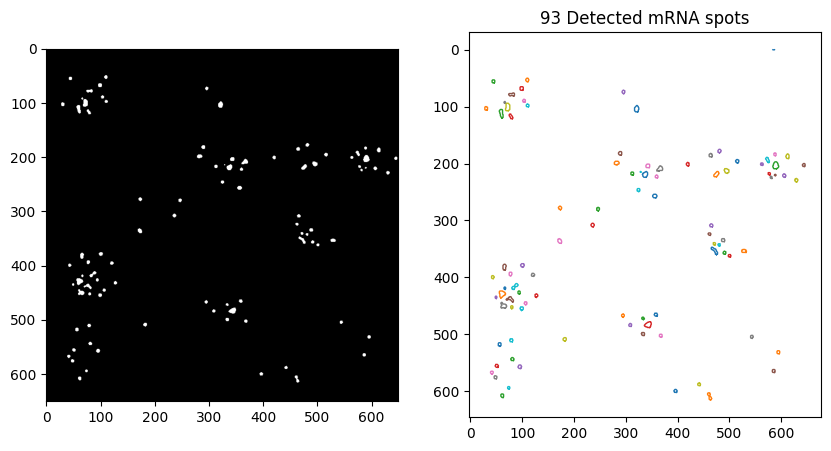

In [5]:
# mRNA identification
threshold_m = 0.025

fig, ax = plt.subplots(1,2,figsize=(10, 5))

mRNA = img[0, :, :, 2]
mRNA_filtered = difference_of_gaussians(mRNA,low_sigma=1, high_sigma=5)

mRNA_binary = mRNA_filtered.copy()
mRNA_binary[mRNA_binary>=threshold_m] = threshold_m # Making spots above the threshold equal to the threshold value.
mRNA_binary[mRNA_binary<threshold_m] = 0 # Making spots below the threshold equal to 0.

mRNA_binary[mRNA_binary!=0] = 1 # Binarization
ax[0].imshow(mRNA_binary, cmap='gray')
spot_contours = measure.find_contours(mRNA_binary, 0.9)

for contour in spot_contours:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1)
ax[1].set(title= str(len(spot_contours))+' Detected mRNA spots' )
ax[1].invert_yaxis()
plt.show()

labels_m = measure.label(mRNA_binary)


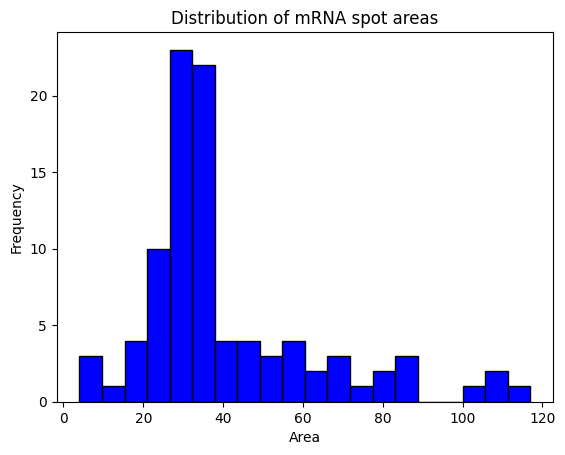

In [6]:
# Use foci size to calculate the number of mRNAs in each detected spot

props = measure.regionprops(labels_m, intensity_image=mRNA)

# Initialize a list to store the intensities
intensities = []
areas = []

# Loop through each mRNA in the image
for prop in props:
    # Calculate the area of the current mRNA spot and add it to the list
    areas.append(prop.area)
# Plot the distribution of intensities
plt.hist(areas, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of mRNA spot areas')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

# Calculate the area of a single mRNA molecule
areas = np.array(areas)
areas_sorted = np.sort(areas)
start = np.percentile(areas_sorted, 10) # select areas between 10th and 50th percentile
end = np.percentile(areas_sorted, 50)
selected_areas = areas_sorted[(areas_sorted>=start) & (areas_sorted<=end)]
single_mRNA_area = np.mean(selected_areas)

In [7]:
# get the number of mRNAs molecules in the nucleus
cell_id = np.unique(masks_cyto)
df_m_c = pd.DataFrame(columns=['Cell Label', 'Total mRNA Area', 'mRNA Count in Nucleus'])

for id in cell_id:
    # Skip the background
    if id == 0:
        continue

    # Get the mask for the current cell
    nuc_mask = (masks_nuc == id)

    # Calculate the properties of the mRNAs in the current cell
    props = measure.regionprops(labels_m * nuc_mask, intensity_image = mRNA)

    # Initialize the total area, total intensity and count for the current cell
    total_area = 0
    count = 0

    # Loop through each mRNA in the current cell
    for prop in props:
        # Update the total area, total intensity and count
        total_area += prop.area

    count = round(total_area / single_mRNA_area)
    # Add the results for the current cell to the DataFrame
    df_m_c.loc[len(df_m_c)] = [id, total_area, count]
df_m_c

,Cell Label,Total mRNA Area,mRNA Count in Nucleus
0,1.0,247.0,9.0
1,2.0,83.0,3.0
2,3.0,0.0,0.0
3,4.0,204.0,7.0
4,5.0,136.0,5.0
5,6.0,219.0,8.0
6,7.0,1.0,0.0
7,8.0,136.0,5.0
8,9.0,317.0,11.0
9,10.0,163.0,6.0


In [8]:
# get the number of mRNAs molecules in the cytoplasm
df_m_c = pd.DataFrame(columns=['Cell Label', 'Total mRNA Area', 'mRNA Count in Cytoplasm'])

for id in cell_id:
    # Skip the background
    if id == 0:
        continue

    # Get the mask for the current cell
    mask_c = (masks_cyto == id)
    mask_n = (masks_nuc == id)
    cyto_mask = mask_c & ~mask_n

    # Calculate the properties of the mRNAs in the current cell
    props = measure.regionprops(labels_m * cyto_mask, intensity_image = mRNA)

    # Initialize the total area, total intensity and count for the current cell
    total_area = 0
    count = 0

    # Loop through each mRNA in the current cell
    for prop in props:
        # Update the total intensity and count
        total_area += prop.area

    count = round(total_area / single_mRNA_area)
    # Add the results for the current cell to the DataFrame
    df_m_c.loc[len(df_m_c)] = [id, total_area, count]
df_m_c

,Cell Label,Total mRNA Area,mRNA Count in Cytoplasm
0,1.0,227.0,8.0
1,2.0,25.0,1.0
2,3.0,0.0,0.0
3,4.0,211.0,7.0
4,5.0,98.0,3.0
5,6.0,180.0,6.0
6,7.0,139.0,5.0
7,8.0,163.0,6.0
8,9.0,375.0,13.0
9,10.0,113.0,4.0


number and intensity of transcription site in each cell

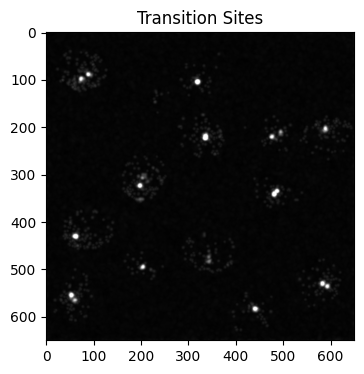

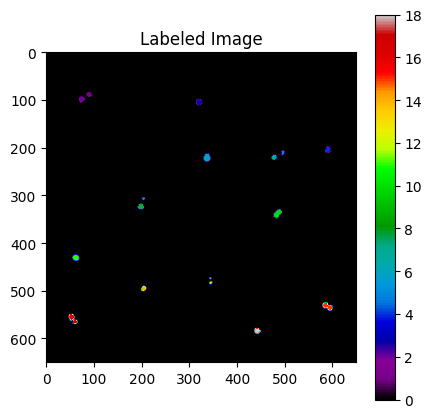

In [13]:
trans_site = np.max(img[:, :, :, 2], axis=0)

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(trans_site, cmap='gray')
plt.title('Transition Sites')
plt.show()

# Apply a threshold to segment the transition sites
threshold = filters.threshold_otsu(trans_site)
binary_trans = trans_site > threshold

# Label connected components
labeled_trans, num_labels = ndi.label(binary_trans)

plt.figure(figsize=(5,5))
plt.imshow(labeled_trans, cmap='nipy_spectral')
plt.colorbar()
plt.title('Labeled Image')
plt.show()

In [14]:
# Initialize an empty DataFrame
df_trans = pd.DataFrame()

# Initialize an empty list to store the cell each region belongs to
cell_labels = []

# Loop over each frame in the image
for i in range(img.shape[0]):
    # Calculate the properties of each region for the current frame
    regions = measure.regionprops(labeled_trans, intensity_image=img[i,:,:,2])
    
    # Get the mean intensity of each region
    brightness = [region.mean_intensity for region in regions]
    
    # Add the brightness values to the DataFrame
    df_trans['frame'+str(i+1)] = brightness

# Loop over each region
for region in regions:
    # Get the coordinates of the region
    coords = region.coords
    
    # Get the labels of the cells that the region belongs to in masks_cyto
    labels = masks_cyto[coords[:,0], coords[:,1]]
    
    # Get the most common label, which is the cell that the region belongs to
    cell_label = np.argmax(np.bincount(labels))
    
    # Add the cell label to the list
    cell_labels.append(cell_label)

# Add the cell labels to the DataFrame
df_trans.insert(0, 'cell', cell_labels)

df_trans

,cell,frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9,...,frame12,frame13,frame14,frame15,frame16,frame17,frame18,frame19,frame20,frame21
0,1,28.946809,187.765957,86.563830,68.648936,146.234043,99.053191,73.531915,37.053191,28.989362,...,31.106383,28.563830,27.829787,31.414894,29.053191,25.042553,29.680851,32.521277,28.702128,114.765957
1,1,83.960784,60.882353,183.019608,97.823529,41.068627,30.352941,31.264706,31.686275,27.558824,...,30.068627,30.813725,29.215686,32.372549,29.931373,28.274510,33.500000,33.274510,29.843137,28.784314
2,2,64.844262,44.704918,35.647541,30.377049,30.163934,51.786885,41.270492,52.860656,51.360656,...,149.426230,72.950820,68.114754,36.016393,132.688525,87.745902,94.622951,219.860656,152.860656,62.942623
3,6,170.100917,126.422018,60.862385,34.403670,26.990826,58.715596,51.550459,34.862385,39.293578,...,30.798165,30.100917,32.990826,84.321101,71.422018,84.100917,79.321101,51.412844,42.266055,30.238532
4,5,57.437500,59.479167,40.312500,29.604167,29.979167,32.833333,145.250000,112.125000,46.000000,...,31.687500,34.479167,29.916667,27.916667,31.270833,27.166667,25.416667,34.125000,30.229167,75.604167
5,4,66.873563,66.074713,32.459770,55.724138,34.678161,173.660920,86.488506,43.810345,36.977011,...,28.172414,36.097701,68.367816,55.195402,75.482759,180.091954,86.459770,54.206897,65.896552,173.931034
6,5,48.176471,38.647059,30.988235,32.564706,31.600000,92.976471,48.211765,158.235294,73.047059,...,28.388235,29.129412,29.235294,29.117647,118.552941,63.352941,187.647059,88.800000,67.811765,43.658824
7,7,31.956522,135.826087,118.260870,76.086957,27.913043,29.260870,29.869565,28.304348,30.086957,...,28.260870,26.260870,30.304348,30.478261,30.173913,28.000000,29.130435,29.913043,29.782609,31.869565
8,7,29.461538,201.490385,102.750000,60.307692,42.923077,27.961538,31.567308,63.682692,52.625000,...,36.701923,35.442308,37.980769,39.769231,89.605769,37.394231,30.432692,30.894231,27.894231,28.490385
9,8,41.724490,33.260204,27.933673,28.698980,32.173469,29.668367,29.362245,63.816327,49.306122,...,34.729592,67.193878,107.147959,48.316327,40.887755,162.612245,155.846939,66.693878,84.683673,149.193878


In [15]:
# Count the number of transcription sites for each cell
transcription_sites_per_cell = df_trans['cell'].value_counts()

transcription_sites_per_cell

1     2
5     2
7     2
10    2
13    2
2     1
6     1
4     1
8     1
9     1
11    1
12    1
14    1
Name: cell, dtype: int64